# Notebook to generate RAS maps - pinkbombs
## PROVISIONAL

General imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [3]:
import folium
import branca.colormap as cm
from branca.element import Template, MacroElement

In [4]:
import zipfile 
import os 

In [5]:
import fiona 
import geopandas as gpd 
from bs4 import BeautifulSoup 

In [6]:
import requests

## 1 - Inputs

### 1.1 - RAS dataset adapted from Esther (Google Sheet)

In [7]:
# Load adapted dataset - download from Google sheet
ras_file = "data_ras/Projets RAS Locations.xlsx - RAS.csv" #Projets_RAS3.csv
projets_ras = pd.read_csv(ras_file) #, encoding='unicode_escape')

https://docs.google.com/spreadsheets/d/1vtZzw8y8IrfWjK2ItR33ApJ0ww10r7_n/edit?usp=sharing&ouid=113313479374754815448&rtpof=true&sd=true

In [8]:
projets_ras.columns.values
projets_ras.shape

(140, 24)

In [9]:
projets_ras.head(3)

,Company,Parent company,Production moyenne,Production Max,Final production data,Abattage,Infos,Technologie,Etat d'avancement,Date permis,...,Species,Latest update,Country,Location,Matching Location,Comment on location,Location source,Latitude,Longitude,Errors found
0,Andfjord Salmon (Kvalnes),Andfjord Salmon,NaN,"39,000",NaN,non,passage à la phase 2 càd de 1000 à 19000 tonn...,FTS,En fonctionnement,NaN,...,NaN,NaN,Norway,"Kvalnes, Andøya",Kvalnes,NaN,NaN,69.158148,16.093888,C'est du FTS (Flow Through Systems) et pas RAS
1,Atlantic Sapphire,Atlantic Sapphire,"1,000","200,000",NaN,oui,https://www.fishfarmingexpert.com/atlantic-sap...,RAS,En fonctionnement,NaN,...,NaN,2023.0,United States,"Homstead, Florida",NaN,"Homstead, Miami-Dade County, Florida",https://www.fishfarmingexpert.com/atlantic-sap...,25.468759,-80.481078,"Correct production from 9,500 to 200,000 based..."
2,Quality Salmon,Quality Salmon,NaN,"100,000",NaN,non,https://www.seafoodsource.com/news/aquaculture...,RAS,Conceptuel,NaN,...,NaN,NaN,Sweden,"Sotenäs, Kungshamn",Kungshamn,NaN,https://www.seafoodsource.com/news/aquaculture...,NaN,NaN,NaN


### 1.2 - GHG Emissions by country for Data enrichment  

In [10]:
# Load data for Carbon intensity of electricity generation by country
carbon_file = "data_ras/carbon-intensity-electricity.csv" 
carbon_elec = pd.read_csv(carbon_file) 

https://www.sciencedirect.com/science/article/pii/S0144860923000171

In [28]:
# For each country, take most recent data point (2022, if not 2021,...)
carbon_elec22 = carbon_elec.loc[carbon_elec.groupby('Entity').Year.idxmax()]
#carbon_elec22 = carbon_elec.loc[carbon_elec['Year'] == 2022,]
carbon_elec22.head(10)

,Entity,Code,Year,Carbon intensity of electricity - gCO2/kWh
22,ASEAN (Ember),NaN,2022,508.204220
44,Afghanistan,AFG,2021,120.481926
66,Africa,NaN,2021,484.696530
88,Africa (Ember),NaN,2021,484.696470
110,Albania,ALB,2021,23.437498
132,Algeria,DZA,2021,485.489500
154,American Samoa,ASM,2021,687.500000
176,Angola,AGO,2021,195.982960
198,Antigua and Barbuda,ATG,2021,657.142900
221,Argentina,ARG,2022,344.306800


In [114]:
#carbon_elec22.sort_values('Carbon intensity of electricity - gCO2/kWh', ascending=False).head(10)
carbon_elec22.loc[carbon_elec22.Entity.isin(['Norway', 'United States', 'France', 
                                             'Portugal', 'China', 'United Kingdom', 
                                             'Iceland', 'Saudi Arabia']), ].sort_values('Carbon intensity of electricity - gCO2/kWh', ascending=False)

,Entity,Code,Year,Carbon intensity of electricity - gCO2/kWh
4114,Saudi Arabia,SAU,2022,557.782800
982,China,CHN,2022,533.982800
4911,United States,USA,2022,368.101960
4888,United Kingdom,GBR,2022,261.154900
3834,Portugal,PRT,2022,234.604720
1696,France,FRA,2022,84.879000
3541,Norway,NOR,2022,28.924809
2210,Iceland,ISL,2021,28.556593


In [12]:
## Merge with RAS dataset
projets_ras = projets_ras.merge(carbon_elec22, left_on='Country', right_on='Entity', how='left')
#projets_ras.head()

### 1.3 - Conversion parameters

In [13]:
# Electricity consumption per kg of salmon produced
elec_per_kg = 9.59 #kWh/kg == 9.59 * 1000 / tonne

https://ourworldindata.org/grapher/carbon-intensity-electricity?tab=table

In [14]:
# Carbon footprint of farmed salmon
carbon_per_kg = 57 #kg C02 equ / kg LW == 57t C02 / t LW 

- 10 FULL SUPPLY CHAIN inc. transport - WWF - https://www.worldwildlife.org/publications/measuring-and-mitigating-ghgs-salmon
- 5.77 - Agribalyse - https://agribalyse.ademe.fr/app/aliments/26036#Saumon,_cru,_élevage
- 57 - Land-based - Compassion in Animal Farming - CIWF, International Salmon Farmers Association (2015) The evolution of land based Atlantic salmon farms

In [15]:
# Convert Production to integer
projets_ras['Production Max'] = projets_ras['Production Max'].apply(lambda x: np.nan if pd.isna(x) else int(x.replace(',','')))

# Calculate Electricity consumption for each farm
projets_ras['elec_conso_kWh'] = projets_ras['Production Max']*elec_per_kg*1000

In [16]:
# Calculate CO2 emissions for each farm from Electricity consumption of country for each farm
# convert g CO2 into tons CO2 (1e6)
projets_ras['carbon_elec_t'] = projets_ras['elec_conso_kWh'] * projets_ras['Carbon intensity of electricity - gCO2/kWh']/1000000

In [17]:
# Calculate CO2 emissions directly from production for each farm
projets_ras['carbon_footprint_t'] = projets_ras['Production Max']*carbon_per_kg

### 1.4 - Data Filtering - SCOPE

In [18]:
# Remove Smolt and species obviously wrong for now !!!! TO IMPROVE!!!
#projets_ras["Species"].value_counts()
species_no = ['Yellow tail', 'Shrimp', 'Smolt', 'Patagonia King Salmon smolt']
projets_ras = projets_ras.loc[~projets_ras["Species"].isin(species_no), ]

In [19]:
projets_ras.shape

(136, 31)

## 2 - Exploratory Data Analysis

### 2.1 - Status

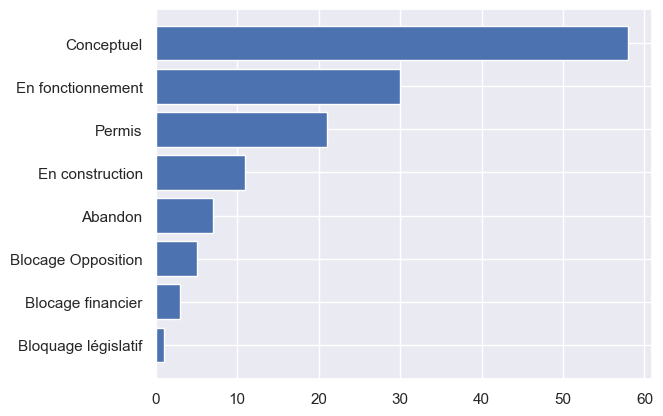

In [20]:
# Histogram of stages
df = projets_ras["Etat d'avancement"].value_counts().reset_index().sort_values(by=['count'])
plt.barh(y=df["Etat d'avancement"], width=df['count'])
plt.show()

In [21]:
# Categorise Etat d'avanncement into 3 status in english
concept = ['Blocage Opposition', 'Blocage financier', 'Bloquage législatif', 'Conceptuel', 'Permis']
projets_ras['Status'] = np.where(
    projets_ras["Etat d'avancement"].isin(concept), 'Project', np.where(
        projets_ras["Etat d'avancement"] == "Abandon", "Abandonned", np.where(
            projets_ras["Etat d'avancement"] == 'En construction', "In construction", np.where(
                projets_ras["Etat d'avancement"] == 'En fonctionnement', "Operating", "NA"
    ))))
projets_ras.groupby(["Status", "Etat d'avancement"]).size()

Status           Etat d'avancement  
Abandonned       Abandon                 7
In construction  En construction        11
Operating        En fonctionnement      30
Project          Blocage Opposition      5
                 Blocage financier       3
                 Bloquage législatif     1
                 Conceptuel             58
                 Permis                 21
dtype: int64

In [22]:
# Aggregate the table by countries and etat d'avancement
ras_country = projets_ras.groupby(["Country", "Etat d'avancement"]).size().reset_index()
ras_country.columns = ["Country", "Avancement", "count"]
ras_country = ras_country.pivot_table(values='count', index=['Country'], columns=["Avancement"], aggfunc="sum").fillna(0).reset_index()

In [23]:
# Caluclate total number of farms for each country
col_sum = ['Abandon', 'Blocage Opposition', 'Blocage financier', 'Conceptuel', 'En construction', 'En fonctionnement', 'Permis']
ras_country['tot_ras_farms'] = ras_country[col_sum].sum(axis=1)
ras_country.head()

Avancement,Country,Abandon,Blocage Opposition,Blocage financier,Bloquage législatif,Conceptuel,En construction,En fonctionnement,Permis,tot_ras_farms
0,Belgium,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,Brunei,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,Canada,0.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,7.0
3,Chile,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0
4,China,1.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,8.0


### 2.1 - Energy Consumption

Text(0, 0.5, 'Number of farms')

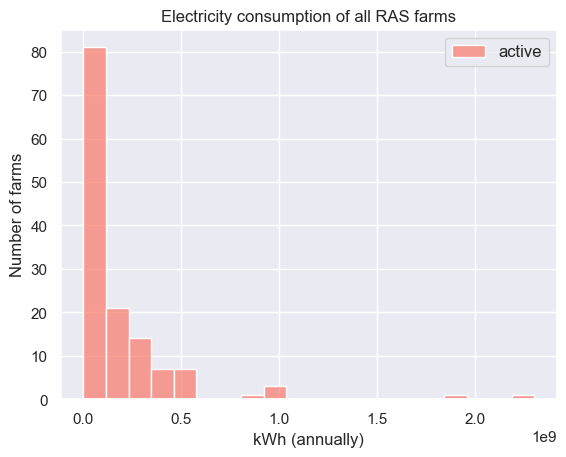

In [29]:
# Histogram of Elec cons
fig, axs = plt.subplots(1, 1)
sns.set(style="darkgrid")
sns.histplot(projets_ras['elec_conso_kWh'], label='active', bins=20, color="salmon", ax = axs)
axs.legend(prop={'size': 12})
axs.set_title('Electricity consumption of all RAS farms')
axs.set_xlabel('kWh (annually)')
axs.set_ylabel('Number of farms')

In [ ]:
## Plot Carbon footprint vs. elec production

Text(0, 0.5, 'Number of farms')

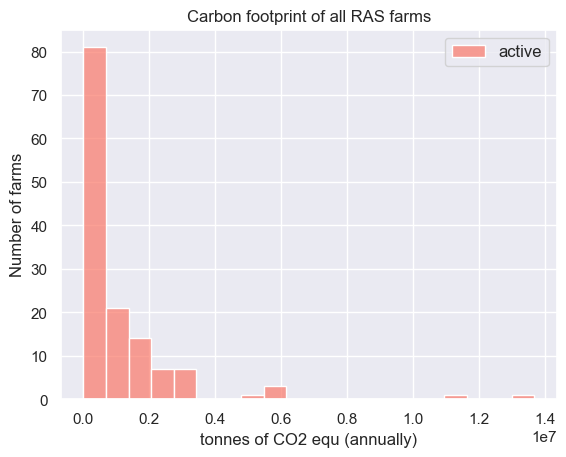

In [25]:
# Histogram of Carbon footprint
fig, axs = plt.subplots(1, 1)
sns.set(style="darkgrid")
sns.histplot(projets_ras['carbon_footprint_t'], label='active', bins=20, color="salmon", ax = axs)
axs.legend(prop={'size': 12})
axs.set_title('Carbon footprint of all RAS farms')
axs.set_xlabel('tonnes of CO2 equ (annually)')
axs.set_ylabel('Number of farms')

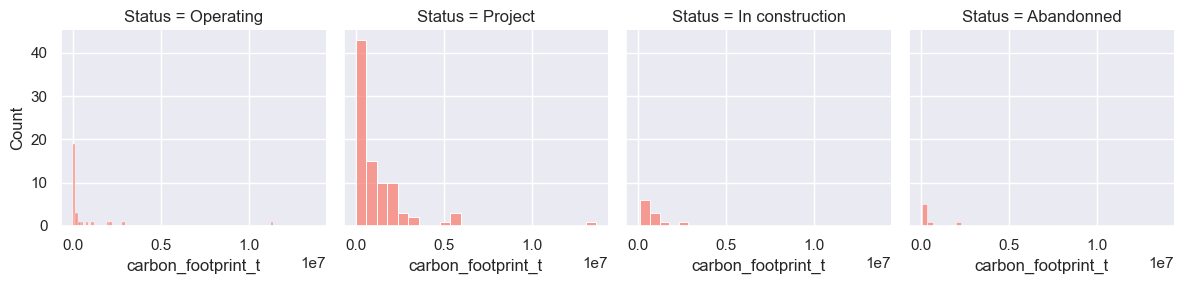

In [26]:
g = sns.FacetGrid(projets_ras, col="Status")
g.map(sns.histplot, 'carbon_footprint_t', color="salmon")

Text(0, 0.5, 'Number of farms')

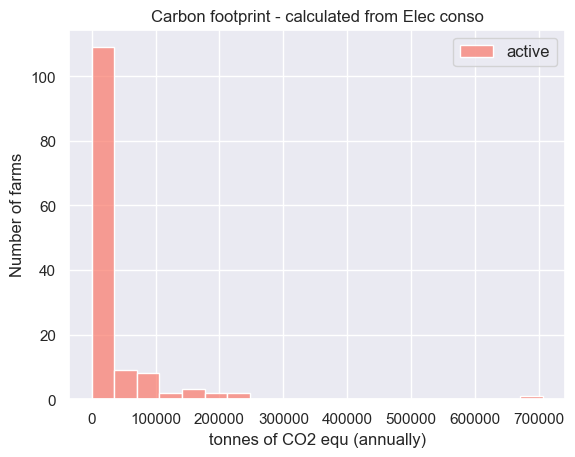

In [30]:
# Histogram of Carbon footprint
fig, axs = plt.subplots(1, 1)
sns.set(style="darkgrid")
sns.histplot(projets_ras['carbon_elec_t'], label='active', bins=20, color="salmon", ax = axs)
axs.legend(prop={'size': 12})
axs.set_title('Carbon footprint - calculated from Elec conso')
axs.set_xlabel('tonnes of CO2 equ (annually)')
axs.set_ylabel('Number of farms')

### 3 - Transform dataset into geopandas with Lat/Long Coordinates

In [31]:
# Load coordinates dataset 
cities = gpd.read_file('data_ras/geonames-all-cities-with-a-population-1000.geojson')
#cities.head()

https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/geonames-all-cities-with-a-population-1000/exports/json?lang=en&timezone=Europe%2FBerlin

In [32]:
#cities.cou_name_en.value_counts().reset_index().head(50)

In [33]:
# New column for country names to match geo dataset
projets_ras['CountryG'] = projets_ras['Country']
projets_ras.loc[projets_ras['CountryG'] == 'Russia', 'CountryG'] = 'Russian Federation'
projets_ras.loc[projets_ras['CountryG'] == 'Vietnam', 'CountryG'] = 'Viet Nam'
projets_ras.loc[projets_ras['CountryG'] == 'Brunei', 'CountryG'] = 'Brunei Darussalam'

### 3.1 - Part 1

In [34]:
# PART 1 - Farms with LatLong coord
projets_ras_co1 = projets_ras.loc[projets_ras['Latitude'].isna() == False,]

In [35]:
projets_ras_co1.shape

(78, 33)

In [36]:
# Create geopandas
projets_ras_co1_gpd = gpd.GeoDataFrame(projets_ras_co1,
                                 geometry=gpd.points_from_xy(projets_ras_co1['Longitude'], projets_ras_co1['Latitude']), 
                                 crs="EPSG:4326")
projets_ras_co1_gpd.head()

,Company,Parent company,Production moyenne,Production Max,Final production data,Abattage,Infos,Technologie,Etat d'avancement,Date permis,...,Entity,Code,Year,Carbon intensity of electricity - gCO2/kWh,elec_conso_kWh,carbon_elec_t,carbon_footprint_t,Status,CountryG,geometry
0,Andfjord Salmon (Kvalnes),Andfjord Salmon,NaN,39000.0,NaN,non,passage à la phase 2 càd de 1000 à 19000 tonn...,FTS,En fonctionnement,NaN,...,Norway,NOR,2022,28.924809,3.740100e+08,10818.167814,2223000.0,Operating,Norway,POINT (16.09389 69.15815)
1,Atlantic Sapphire,Atlantic Sapphire,"1,000",200000.0,NaN,oui,https://www.fishfarmingexpert.com/atlantic-sap...,RAS,En fonctionnement,NaN,...,United States,USA,2022,368.101960,1.918000e+09,706019.559280,11400000.0,Operating,United States,POINT (-80.48108 25.46876)
5,Norwegian Mountain Salmon,Norwegian Mountain Salmon,NaN,90000.0,NaN,NaN,https://thefishsite.com/articles/is-lewis-set-...,Hybrid FTS/RAS,Conceptuel,NaN,...,United Kingdom,GBR,2022,261.154900,8.631000e+08,225402.794190,5130000.0,Project,United Kingdom,POINT (-7.10202 58.10483)
7,Andfjord Salmon (Breivik),Andfjord Salmon,NaN,25000.0,NaN,non,https://www.rastechmagazine.com/fish-growth-ex...,FTS,Permis,NaN,...,Norway,NOR,2022,28.924809,2.397500e+08,6934.722958,1425000.0,Project,Norway,POINT (16.06147 69.21970)
8,Andfjord Salmon (Fiskenes),Andfjord Salmon,NaN,25000.0,NaN,non,https://www.rastechmagazine.com/fish-growth-ex...,FTS,Conceptuel,NaN,...,Norway,NOR,2022,28.924809,2.397500e+08,6934.722958,1425000.0,Project,Norway,POINT (16.14947 69.25790)


### 3.2 - Part 2

In [37]:
# Part 2 - Farms with no coordinates but locations  --> simple matching
projets_ras_loc = projets_ras.loc[(projets_ras['Location'].isna() == False) & (projets_ras['Latitude'].isna()),]

In [38]:
# Merge geometry to original dataset
#projets_ras_locxy = projets_ras_loc.merge(cities_sub[['name', 'geometry']], left_on='Location', right_on='name', how='left')
#type(projets_ras_locxy)

In [39]:
# Match on location AND country
projets_ras_locxyB = projets_ras_loc.merge(cities[['name', 'cou_name_en', 'geometry']], how='left',
                                           left_on=['Matching Location', 'CountryG'], 
                                           right_on=['name', 'cou_name_en'])

In [40]:
# How many not found?
sum(projets_ras_locxyB['name'].isna())

2

In [41]:
## Show those not found through matching
projets_ras_locxyB.loc[projets_ras_locxyB['name'].isna(),['Company', 'Country', 'CountryG', 'Location', 'Matching Location', 
                                                          'Comment on location', 'name', 'geometry']]

,Company,Country,CountryG,Location,Matching Location,Comment on location,name,geometry
9,Eco Seafood,Norway,Norway,Træna ?,NaN,NaN,NaN,None
33,Smogenlax,Norway,Norway,Kungshamn,Kungshamn,Kungshamn,NaN,None


In [42]:
# Set dataframe for part 2 dropping the 2 columns not in part 1
projets_ras_co2 = projets_ras_locxyB.loc[projets_ras_locxyB['name'].isna() == False,].drop(columns=['name', 'cou_name_en'])

In [43]:
#projets_ras_co2.columns.values
projets_ras_co2.shape

(49, 34)

In [44]:
# Put into GeoDataFrame
projets_ras_co2_gpd = gpd.GeoDataFrame(projets_ras_co2)
#projets_ras_co2_gpd.head()

In [45]:
# Combine Part 1 and Part 2
projets_ras_co_gpd = pd.concat([projets_ras_co1_gpd, projets_ras_co2_gpd]).reset_index()

In [46]:
projets_ras_co_gpd.tail()

,index,Company,Parent company,Production moyenne,Production Max,Final production data,Abattage,Infos,Technologie,Etat d'avancement,...,Entity,Code,Year,Carbon intensity of electricity - gCO2/kWh,elec_conso_kWh,carbon_elec_t,carbon_footprint_t,Status,CountryG,geometry
122,46,Blue Horizon Coho,Blue Horizon Coho,NaN,500.0,NaN,oui,https://www.hishingsmart.com/projects/dongyin...,NaN,En fonctionnement,...,China,CHN,2022,533.98280,4795000.0,2560.447526,28500.0,Operating,China,POINT (118.49165 37.46271)
123,47,Tianjin Changjiufada,Tianjin Changjiufada,NaN,500.0,NaN,non,https://documentcloud.adobe.com/gsuiteintegrat...,NaN,Abandon,...,China,CHN,2022,533.98280,4795000.0,2560.447526,28500.0,Abandonned,China,POINT (117.17667 39.14222)
124,48,Taste of BC,Blue star Foods,100,400.0,NaN,non,https://www.fishfarmingexpert.com/british-colu...,NaN,En fonctionnement,...,Canada,CAN,2022,125.84192,3836000.0,482.729605,22800.0,Operating,Canada,POINT (-123.94003 49.16638)
125,49,BDV /SAS,BDV /SAS,NaN,100.0,NaN,oui,https://www.pdm-seafoodmag.com/lactualite/saum...,NaN,En fonctionnement,...,France,FRA,2022,84.87900,959000.0,81.398961,5700.0,Operating,France,POINT (-1.10384 49.31604)
126,50,West Creek Aquaculture,West Creek Aquaculture,NaN,90.0,NaN,NaN,https://www.salmonbusiness.com/these-are-the-l...,NaN,En fonctionnement,...,Canada,CAN,2022,125.84192,863100.0,108.614161,5130.0,Operating,Canada,POINT (-121.76926 49.23298)


In [47]:
projets_ras_co_gpd.shape

(127, 35)

## 4 - Map

### 4.1 - Maps element: pop-up box

In [119]:
# Create strings to display on box
projets_ras_co_gpd['Electricity consumption (annual) [MWh]'] = projets_ras_co_gpd['elec_conso_kWh'].apply(
    lambda x: format(int(x/1000), "8,d"))

# Create string for display on pop-up box
projets_ras_co_gpd['Carbon Footprint (annual) [kilo tonnes C02 equ]'] = projets_ras_co_gpd['carbon_footprint_t']/1000
#projets_ras_co_gpd = projets_ras_co_gpd.rename(columns={'Production Max': 'Production Capacity (annual) [tonnes]'})
projets_ras_co_gpd['Production Capacity (annual) [tonnes]'] = projets_ras_co_gpd['Production Max'].apply(
    lambda x: format(int(x), "8,d"))
projets_ras_co_gpd['Carbon Footprint (annual)'] = 'TBC'

In [116]:
projets_ras_co_gpd['Location source']

0                                                    NaN
1      https://www.fishfarmingexpert.com/atlantic-sap...
2      https://www.stornowaygazette.co.uk/business/mo...
3                                                    NaN
4                                                    NaN
                             ...                        
122                      http://en.bheco.cn/aquatic.html
123    https://norne.no/wp-content/uploads/2023/01/La...
124    https://www.fishfarmingexpert.com/british-colu...
125    https://www.pdm-seafoodmag.com/lactualite/saum...
126    https://www.salmonbusiness.com/these-are-the-l...
Name: Location source, Length: 127, dtype: object

In [120]:
# Create hyperlinks for the locations
projets_ras_co_gpd['Location source link'] = '''<a href='https://www.norne.no' target='_blank'>Location source</a>'''

#= projets_ras_co_gpd['Location source'].apply(
#    lambda x: format(int(x), "8,d"))

In [ ]:
<a href='https://www.norne.no' target='_blank'>Location source</a>


In [ ]:
<a href=https://www.dingsbums.lu>https://www.dingsbums.lu</a>

In [121]:
# Choose fields to display in tooltip 
fields=['Company', 
            "Country", 
            'Location',
            'Location source link',
            'Status',
            'Species', 
            #"Etat d'avancement ", 
            #'Production moyenne ', 
            "Production Capacity (annual) [tonnes]",
            "Electricity consumption (annual) [MWh]",
            "Carbon Footprint (annual)"
            #"Carbon Footprint (annual) [kilo tonnes C02 equ]"
            #'Abattage ', 
            #'Infos',  
            #'Investisseurs ', 
            #'Coût \x80 ',         
       ]

### 4.2 - Maps element: Bubble radius

In [122]:
def get_transfo_param(df, col, min_rad=2.5, max_rad=60):
    """Returns the linear parameters to convert a dataframe field for display as bubble on a map 
            Parameters:
                    df (DataFrame): Dataframe containing data to display
                    col (str): Name of the column to display as bubble on the map
                    min_rad (float): min size of circle on the map, default is 2.5
                    max_rad (float): min size of circle on the map, default is 60
            Returns:
                    (slope, intercept) (pair): Pair of float as parameters of the linear transformation
    """  
    minx = df[col].min()
    maxx = df[col].max()
    slope = (max_rad - min_rad)/(maxx - minx) 
    intercept = max_rad - slope * maxx 
    return (slope, intercept)

In [123]:
# Determine transformation for display on the map - ELECTRICITY
(a_elec, b_elec) = get_transfo_param(projets_ras_co_gpd, 'elec_conso_kWh', min_rad=2.5, max_rad=60)

In [124]:
(a_elec, b_elec)

(2.4991992782834057e-08, 2.4784294110291327)

### 4.3 - Pinkbombs map

In [126]:
# Map centered on World
map_bubras1 = folium.Map(location=(0, 0), zoom_start=2, tiles='cartodb positron') #tiles='openstreetmap')

In [127]:
# Define list of 4 colors for each Status
shades_salmon = ['#CBC1AE', #oyster grey
                 '#C66264', #dark salmon
                 '#fa8072', #salmon
                 '#FEA993', #light salmon
                ]

Colors from https://creativebooster.net/blogs/colors/shades-of-salmon-color

In [128]:
def add_map_bubbles(map, df, col, a, b, my_colors):
    """Returns folium maps with bubbles for one particular field in the geopandas dataframe 
            Parameters:
                    map (folium object): Folium Map 
                    df (Geopandas DataFrame): Dataframe containing data to display
                    col (str): Name of the column to display as bubble on the map
                    a (float): slope as parameter of the linear transformation
                    b (float): intercept as parameter of the linear transformation
                    my_colors (list): color codes for the 4 different status
            Returns:
                    map (folium object): Folium Map with bubbles added
    """  
    fg1 = folium.FeatureGroup(name='Abandonned')
    fg2 = folium.FeatureGroup(name='Operating')
    fg3 = folium.FeatureGroup(name='In construction')
    fg4 = folium.FeatureGroup(name='Project')
  
    for index, row in df.iterrows():
        if row["Status"] == 'Abandonned':
            folium.CircleMarker(
                location=[row['geometry'].y, row['geometry'].x],
                radius=float(row[col] * a + b),
                color=my_colors[0],
                fill=True,
                fill_color=my_colors[0],
                fill_opacity=0.6,
                opacity=0.8,
                tooltip = row[fields].to_frame().to_html(),
            #).add_to(map)
            ).add_to(fg1)
            
        if row["Status"] == 'Operating':
            folium.CircleMarker(
                location=[row['geometry'].y, row['geometry'].x],
                radius=float(row[col] * a + b),
                color=my_colors[1], 
                fill=True,
                fill_color=my_colors[1],
                fill_opacity=0.6,
                opacity=0.8,
                tooltip = row[fields].to_frame().to_html(),
            ).add_to(fg2)
            
        if row["Status"] == 'In construction':
            folium.CircleMarker(
                location=[row['geometry'].y, row['geometry'].x],
                radius=float(row[col] * a + b),
                color=my_colors[2], 
                fill=True,
                fill_color=my_colors[2],
                fill_opacity=0.6,
                opacity=0.8,
                tooltip = row[fields].to_frame().to_html(),
            ).add_to(fg3)
            
        if row["Status"] == 'Project':
            folium.CircleMarker(
                location=[row['geometry'].y, row['geometry'].x],
                radius=float(row[col] * a + b),
                color=my_colors[3], 
                fill=True,
                fill_color=my_colors[3],
                fill_opacity=0.6,
                opacity=0.8,
                tooltip = row[fields].to_frame().to_html(),
            ).add_to(fg4)

    map.add_child(fg1)
    map.add_child(fg2)
    map.add_child(fg3)
    map.add_child(fg4)
    folium.LayerControl().add_to(map)

    return map

In [129]:
# Add bubbles for Electricity consumption
map_bubras2 = add_map_bubbles(map_bubras1, projets_ras_co_gpd, 'elec_conso_kWh', a_elec, b_elec, shades_salmon)

### 4.3 - Maps element: Title

In [130]:
# Add title 
map_title = 'PROVISIONAL MAP: Land-based farms and their theoretical Electricity consumption'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(map_title)   
map_bubras2.get_root().html.add_child(folium.Element(title_html))

### 4.4 - Maps element: Legend

In [131]:
template1 = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; left: 20px; bottom: 20px;'>
"""

In [132]:
template2 = """
<div class='legend-title'>Land-based Farms by Status</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#C66264;opacity:0.7;'></span>Operating</li>
    <li><span style='background:#FA8072;opacity:0.7;'></span>In construction</li>
    <li><span style='background:#FEA993;opacity:0.7;'></span>Project</li>
    <li><span style='background:#CBC1AE;opacity:0.7;'></span>Abandonned</li>
"""

In [133]:
template3 = """
<div class='legend-subtitle'>Size depends on production and MWh</div>
<li><a href='https://www.sciencedirect.com/science/article/pii/S0144860923000171' target='_blank'>based on 9.59 kWh/kg LW (Ayuso-Virgili et al. 2023)</a></li>
"""

In [134]:
template4 = """
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [135]:
template = template1 + template2 + template3 + template4

In [136]:
# Add legend
macro = MacroElement()
macro._template = Template(template)
map_bubras2.get_root().add_child(macro)

In [815]:
map_bubras1.save('outputs/map_ras_bubble_world_PROV_v7.html')

## 5 - Map with Carbon footprint

In [106]:
# Determine transformation for display on the map - CARBON FOOTPRINT
(a_carbon, b_carbon) = get_transfo_param(projets_ras_co_gpd, 'carbon_elec_t', min_rad=2.5, max_rad=60)

In [107]:
(a_carbon, b_carbon)

(8.145189370980717e-05, 2.4933699004805305)

In [108]:
# Map centered on World
map_carbon = folium.Map(location=(0, 0), zoom_start=2, tiles='cartodb positron') #tiles='openstreetmap')

In [109]:
# Add bubbles for Electricity consumption
map_carbon = add_map_bubbles(map_carbon, projets_ras_co_gpd, 'carbon_elec_t', a_carbon, b_carbon, shades_salmon)

In [110]:
# Add title 
map_title = 'PROVISIONAL MAP: Land-based farms and their theoretical Carbon footprint'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(map_title)   
map_carbon.get_root().html.add_child(folium.Element(title_html))

In [111]:
template3_carbon = """
<div class='legend-subtitle'>Size depends on production,</div>
<div class='legend-subtitle'>electricity usage and kg C02 equ</div>
<li><a href='https://www.sciencedirect.com/science/article/pii/S0144860923000171' target='_blank'>based on SOMETHING</a></li>
"""

In [112]:
template = template1 + template2 + template3_carbon + template4

In [113]:
# Add legend
macro = MacroElement()
macro._template = Template(template)
map_carbon.get_root().add_child(macro)